In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from scipy.stats import crystalball
from scipy.optimize import curve_fit
import lmfit

# ORTEC systems:

- Preamplifier: ORTEC 142A, Preamplifier Sensitivity: 45 mV/MeV

- Amplifier: ORTEC 572 A, Set with coarse gain 50 + fine 63, total gain 56.5 

- MCA: Easy MCA, 2048 channels. Main (Ra) peak at channel 984.

- SCA: 550A.

In [22]:
def get_total_gain(dial, coarse_gain = 50):
    Gmin = 0.5
    Gmax = 1.5
    dmin = 0
    dmax = 100
    Gfine = Gmin + (Gmax - Gmin) * (dial - dmin) / (dmax - dmin)
    Gtotal = Gfine * coarse_gain
    return Gtotal

In [52]:
def channel_to_voltage(channel):
    """
    Convert a channel number to voltage and energy peak.
    :param channel: Channel number (0-2047)
    :return: event voltage in mV
    """
    if not (0 <= channel < 2048):
        raise ValueError("Channel must be between 0 and 2047")
    
    V = channel * 10 / 2048 # V
    V_mV = V * 1000 # mV

    print(f"V = {V:.2f} V")
    return V_mV

In [53]:
channel_to_voltage(1530)

V = 7.47 V


7470.703125

In [ ]:
def voltage_to_energy(voltage, fine_gain = 63, coarse_gain = 50):
    """
    Convert a voltage in mV to energy peak in eV.
    :param voltage: Voltage in mV
    :param fine_gain: Fine gain setting (0-63)
    :param coarse_gain: Coarse gain setting (default 50)
    :return: Energy peak in eV
    """
    gain_amp = get_total_gain(fine_gain, coarse_gain)
    gain_preamp = 45 / 1000 # mV / keV preamp gain

    E_peak = voltage / (gain_amp * gain_preamp)# keV
    print(f"E_peak = {E_peak:.2f} KeV")
    return E_peak

voltage_to_energy(7300)

E_peak = 2871.19 KeV


2871.1897738446414

In [54]:
peak_pos = 984 # channel radium
N = peak_pos # channel radium
claimed_energy = 1793.47 # eV
gain_amp = 56.5 # At Coarse 50, fine 63.


voltage = channel_to_voltage(peak_pos)
E_peak = voltage_to_energy(voltage, fine_gain=63, coarse_gain=50)

V = 4.80 V
E_peak = 1889.75 KeV


In [31]:
peak_resolution = 1 # channel resolution
peak_resolution_mV = peak_resolution * 10 / 2048 * 1000 # mV
print(f"Peak resolution = {peak_resolution_mV:.4f} mV")
E_peak_resolution = peak_resolution_mV / (gain_amp * gain_preamp) * 1e3 # keV
print(f"E_peak resolution = {E_peak_resolution:.4f} keV")

Peak resolution = 4.8828 mV
E_peak resolution = 1.9205 keV


## For highest peak (Po 212) E = 8.954 MeV

In [8]:
peak_pos = 1530 # channel radium
N = peak_pos # channel radium
claimed_energy = 1793.47 # eV
fine_dial = 54
gain_amp = get_total_gain(fine_dial, coarse_gain = 50) # At Coarse 50, fine 55.

gain_preamp = 45 # mV / MeV preamp gain


V = N * 10 / 2048 # V
V_mV = V * 1000 # mV
E_peak = V_mV / (gain_amp * gain_preamp) # eV

print(f"V = {V:.2f} V")
print(f"E_peak = {E_peak:.2f} eV")

V = 7.47 V
E_peak = 3.19 eV


In [9]:
gain_amp = get_total_gain(63)
N = 1450
V = N * 10 / 2048 # V
V

7.080078125

# Gating the MCA with the SCA:

Using a T-connector to channel the output of the amplifier to both the SCA and the MCA input. The SCA output is then sent to the GATE of the MCA and set to Coincidences.

For Ra224 only, a Lower Level Discriminator (LLD) of 4.9 V is used, and a window or Upper Level Discriminator (ULD) arbitrarily high, 6.4 V

For Th228 only, the LLD is set to 4.62 V with the same window 6.4 V.

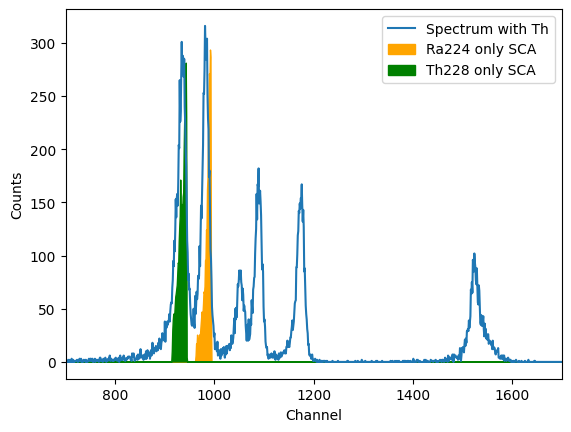

In [10]:
ROOT_PATH = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-pablo.herrero-gomez@mail.huji.ac.il/My Drive/RaTag_data/MCA_spectra'
file_spectrum = ROOT_PATH +'/Second_Th_loaded_detector_in_air2.csv'
df_mca2 = pd.read_csv(file_spectrum, sep='\t', header=0, skiprows=11, nrows=2048, names=['counts'])
plt.plot(df_mca2.counts, label='Spectrum with Th')

file_ra224 = ROOT_PATH +'/Ra224_only_SCA.csv'
df_ra224 = pd.read_csv(file_ra224, sep='\t', header=0, skiprows=11, nrows=2048, names=['counts'])
# plt.plot(df_ra224.counts, label='Ra224 only SCA')
plt.fill_between(df_ra224.index, df_ra224.counts*0.7, color='orange', label='Ra224 only SCA')

file_th228 = ROOT_PATH +'/Th228_only_SCA.csv'
df_th228 = pd.read_csv(file_th228, sep='\t', header=0, skiprows=11, nrows=2048, names=['counts'])
# plt.plot(df_th228.counts, label='Th228 only SCA')
plt.fill_between(df_th228.index, df_th228.counts, color='green', label='Th228 only SCA')

plt.gca().set(xlabel='Channel', ylabel='Counts', xlim=(700, 1700))
plt.legend()

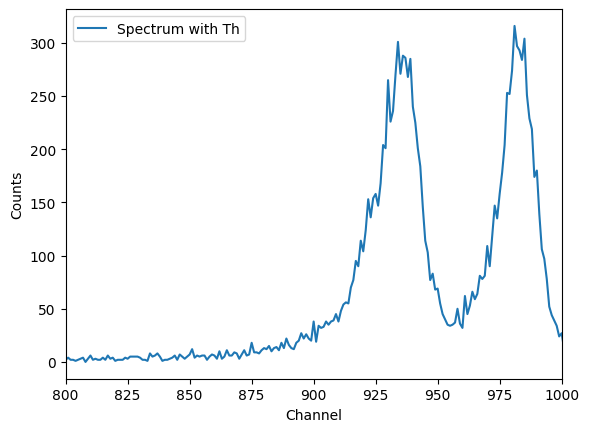

In [11]:
plt.plot(df_mca2.counts, label='Spectrum with Th')


plt.gca().set(xlabel='Channel', ylabel='Counts', xlim=(800, 1000))
plt.legend()

# Fit Th 228 peaks

curve_fit → A =22.672, β=1.150, m=1.730, loc=1173.939, scale=7.327


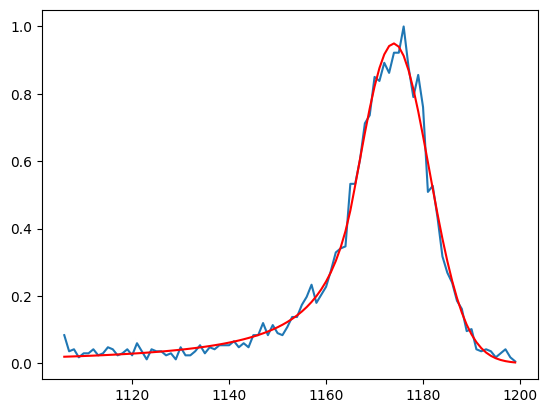

In [12]:
dfdw = df_mca2[(df_mca2.index > 1105)]
dff = dfdw[(dfdw.index < 1200)]

# 2) build PDF function
def crystalball_pdf(x, A, beta, m, loc, scale):
    return A * crystalball.pdf(x, beta, m, loc, scale)

# 3) histogram to get “y” values

# 4) initial guesses: reasonable defaults
x = dff.index.tolist()
x = np.array(x)

y = dff.counts.values
y = y.astype(float)
y /= np.max(y)  # normalize counts

plt.plot(x, y, label='MCA')


p01 = [10., 2., 2.0, np.mean(x), np.std(x)]

# 5) fit
popt, pcov = curve_fit(crystalball_pdf, x, y, p0=p01,
                       bounds=([0, 0, 0, np.min(x), 0],
                               [np.inf, np.inf, np.inf, np.max(x), np.inf]))

A, beta, m, loc, scale = popt
print(f"curve_fit → A ={A:.3f}, β={beta:.3f}, m={m:.3f}, loc={loc:.3f}, scale={scale:.3f}")

plt.plot(x, crystalball_pdf(x, *popt), 'r-', label="fit")

curve_fit → A =22.677, β=1.150, m=1.728, loc=1173.938, scale=7.329


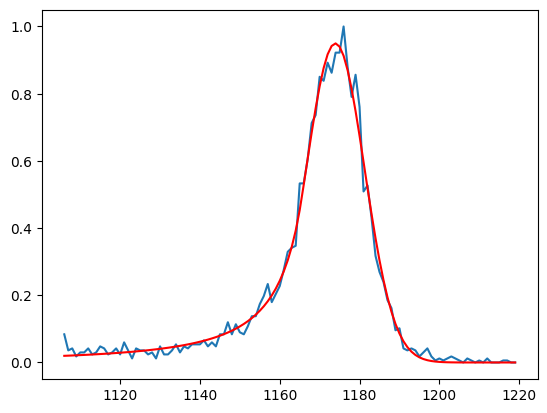

In [13]:
dfdw = df_mca2[(df_mca2.index > 1105)]
dff = dfdw[(dfdw.index < 1220)]

# 2) build PDF function
def crystalball_pdf(x, A, beta, m, loc, scale):
    return A * crystalball.pdf(x, beta, m, loc, scale)

# 3) histogram to get “y” values

# 4) initial guesses: reasonable defaults
x = dff.index.tolist()
x = np.array(x)

y = dff.counts.values
y = y.astype(float)
y /= np.max(y)  # normalize counts
p01 = [11.67, 0.98, 1.97, 1207.379, 3.431]

# 5) fit
popt, pcov = curve_fit(crystalball_pdf, x, y, p0=p01,
                       bounds=([0, 0, 0, np.min(x), 0],
                               [np.inf, np.inf, np.inf, np.max(x), np.inf]))

A, beta, m, loc, scale = popt
print(f"curve_fit → A ={A:.3f}, β={beta:.3f}, m={m:.3f}, loc={loc:.3f}, scale={scale:.3f}")

plt.plot(x, y, label='MCA')
plt.plot(x, crystalball_pdf(x, *popt), 'r-', label="fit")

## Fit 2 crystalball?

[Text(0.5, 0, 'Channel'), Text(0, 0.5, 'Counts'), (900.0, 1100.0)]

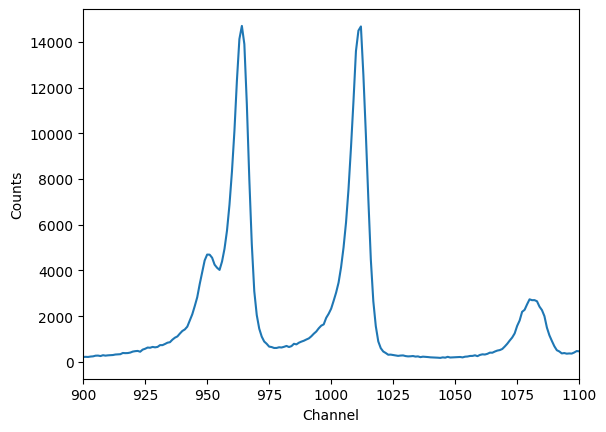

In [14]:
ROOT_PATH = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-pablo.herrero-gomez@mail.huji.ac.il/My Drive/RaTag_data/MCA_spectra'
file_spectrum = ROOT_PATH +'/Second_Th_loaded_detector_in_air.csv'
df_mca = pd.read_csv(file_spectrum, sep='\t', header=0, skiprows=11, nrows=2048, names=['counts'])
plt.plot(df_mca.counts, label='Spectrum with Th')
plt.gca().set(xlabel='Channel', ylabel='Counts', xlim=(900, 1100))

ValueError: `x0` is infeasible.

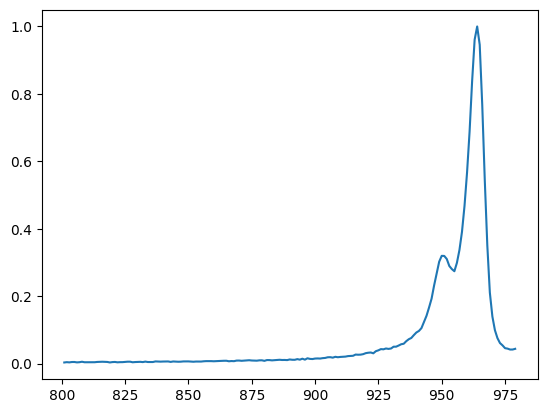

In [16]:
dfdw = df_mca[(df_mca.index > 800)]
# dff = dfdw[(dfdw.index < 1030)]
dff = dfdw[(dfdw.index < 980)]


def mixture_crystalball(x, *params):
    """
    params is a flat tuple of length 5*N: 
      [A1, beta1, m1, loc1, scale1,
       A2, beta2, m2, loc2, scale2,
       …]
    """
    params = np.array(params).reshape(-1, 5)  # shape (N, 5)
    y = np.zeros_like(x, dtype=float)
    for A, beta, m, loc, scale in params:
        y += A * crystalball.pdf(x, beta, m, loc, scale)
    return y

x = dff.index.tolist()
x = np.array(x)
bin_width = x[1] - x[0]  # assuming uniform binning

y = dff.counts.values
y = y.astype(float)
y /= np.max(y)  # normalize counts

# Build initial guesses: 3 quintuples
N = 1
p0 = []
bounds_low = []
bounds_high = []

locs = [950, 965]

for i in range(N):
    # You could do some smart splitting of your data to estimate each peak's loc/scale,
    # but here we just scatter them around the global mean
    # A0     = len(x) * bin_width / N
    # A0     = len(x) * bin_width / (N * 2)  # half the area for each peak
    A0     = 22.677
    beta0  = 1.150
    m0     = 1.728
    loc0   = locs[i]
    scale0 = 7.329
    p0.extend([A0, beta0, m0, loc0, scale0])
    bounds_low.extend([0, 0, 0, y.min(), 0])
    bounds_high.extend([np.inf, np.inf, np.inf, y.max(), np.inf])

plt.plot(x, y, label='MCA')

popt, pcov = curve_fit( mixture_crystalball,
                        x, y,
                        p0=p0,
                        bounds=(bounds_low, bounds_high)
)

# unpack results
components = np.array(popt).reshape(-1, 5)
for i, (A, beta, m, loc, scale) in enumerate(components, 1):
    print(f"Peak #{i}:  A={A:.1f}, β={beta:.2f}, m={m:.2f}, loc={loc:.2f}, scale={scale:.2f}")

x_plot = np.linspace(x.min(), x.max(), 1000)

plt.plot(x, y, label='MCA')
plt.plot(x_plot, mixture_crystalball(x_plot, *popt), 'r-', lw=2, label="3-CB fit")

# Fit with lmfit

In [17]:
def v_crystalball(x, N, beta, m, x0, sigma):
    """
    Vectorized Crystal Ball function.
    """
    abs_beta = np.abs(beta)
    z = (x - x0) / sigma
    if beta < 0:
        z = -z
    # Gaussian part
    gauss = N * np.exp(-0.5 * z**2)
    # Power-law tail
    A = (m/abs_beta)**m * np.exp(-0.5 * abs_beta**2)
    B = m/abs_beta - abs_beta
    tail = N * A / (B - z)**m
    # Piecewise combination
    return np.where(z > -abs_beta, gauss, tail)

model = lmfit.Model(v_crystalball, prefix='cb_')

/var/folders/tb/zxwsw51n6_g6gs5lnxdv2bcr0000gn/T/ipykernel_84837/1508594507.py:14: RuntimeWarning: invalid value encountered in power
  tail = N * A / (B - z)**m


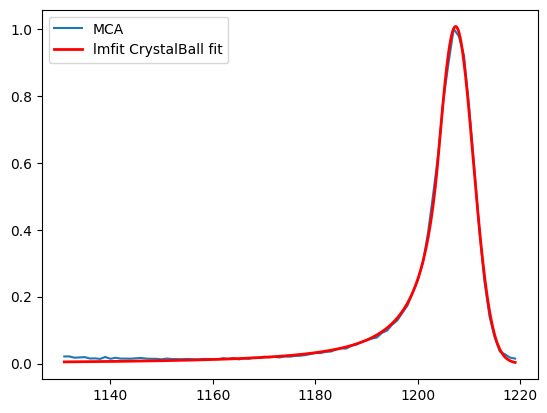

In [18]:
dfdw = df_mca[(df_mca.index > 1130)]
dff = dfdw[(dfdw.index < 1220)]

x = dff.index.tolist()
x = np.array(x)
bin_width = x[1] - x[0]  # assuming uniform binning

y = dff.counts.values
y = y.astype(float)
y /= np.max(y)  # n

x_plot = np.linspace(x.min(), x.max(), 1000)

plt.plot(x, y, label='MCA')
# Set initial parameters
params = model.make_params(
    cb_N=1.677,
    cb_beta=1.150,
    cb_m=1.728,
    cb_x0=1205,    # Try the actual peak center, e.g. 1207
    cb_sigma=7.329
)
params['cb_N'].min = 0.1
params['cb_beta'].min = 0
params['cb_m'].min = 1
params['cb_x0'].min = 0
params['cb_sigma'].min = 0

# Fit the model to the data
result = model.fit(y, x=x, params=params, method='leastsq')


plt.plot(x_plot, result.eval(x=x_plot), 'r-', lw=2, label="lmfit CrystalBall fit")
plt.legend()

In [45]:
result

## Triple crystalball

In [19]:
dfdw = df_mca[(df_mca.index > 800)]
# dff = dfdw[(dfdw.index < 1030)]
dff = dfdw[(dfdw.index < 1030)]

x = dff.index.tolist()
x = np.array(x)
bin_width = x[1] - x[0]  # assuming uniform binning

y = dff.counts.values
y = y.astype(float)
y /= np.max(y)  # n

/var/folders/tb/zxwsw51n6_g6gs5lnxdv2bcr0000gn/T/ipykernel_84837/1508594507.py:14: RuntimeWarning: invalid value encountered in power
  tail = N * A / (B - z)**m


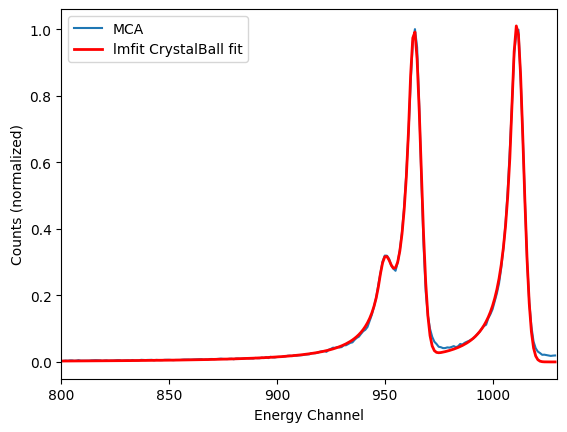

In [21]:
model = (
    lmfit.Model(v_crystalball, prefix='cb1_') +
    lmfit.Model(v_crystalball, prefix='cb2_') +
    lmfit.Model(v_crystalball, prefix='cb3_')
)

params = model.make_params(
    cb1_N=0.31, cb1_beta=1.150, cb1_m=1.728, cb1_x0=950,  cb1_sigma=7.329,
    cb2_N=0.71, cb2_beta=1.150, cb2_m=1.728, cb2_x0=965,  cb2_sigma=7.329,
    cb3_N=0.9,  cb3_beta=1.150, cb3_m=1.728, cb3_x0=1010, cb3_sigma=7.329
)

# Set shared parameters: only cb1_beta, cb1_m, cb1_sigma are free
params['cb2_beta'].expr = 'cb1_beta'
params['cb3_beta'].expr = 'cb1_beta'
params['cb2_m'].expr    = 'cb1_m'
params['cb3_m'].expr    = 'cb1_m'
params['cb2_sigma'].expr = 'cb1_sigma'
params['cb3_sigma'].expr = 'cb1_sigma'

# Set bounds
for i in range(1, 4):
    params[f'cb{i}_N'].min = 0.1
    params[f'cb{i}_x0'].min = 0
params['cb1_beta'].min = 0
params['cb1_m'].min = 1
params['cb1_sigma'].min = 0

# ...fit as before...
result = model.fit(y, x=x, params=params, method='leastsq')
plt.plot(x, y, label='MCA')
plt.plot(x, result.eval(x=x), 'r-', lw=2, label="lmfit CrystalBall fit")
plt.gca().set(xlabel='Energy Channel', ylabel='Counts (normalized)', xlim=(800, 1030))
plt.legend()

In [74]:
result

In [65]:
for par in result.best_values.items():
    if '_x0' in par[0]:
        print(f"{par[0]} = {par[1]:.2f} channel")

cb3_x0 = 1011.17 channel
cb2_x0 = 963.77 channel
cb1_x0 = 949.39 channel


In [76]:
for par in result.best_values.items():
    if 'cb3_' in par[0]:
        print(f"{par[0]} = {par[1]:.2f}")

cb3_N = 1.01
cb3_beta = 0.76
cb3_m = 2.07
cb3_x0 = 1011.25
cb3_sigma = 3.07


# Fit in energy scale

In [ ]:
dff['channel'] = dff.index
dff['energy'] = dff['channel']

/var/folders/tb/zxwsw51n6_g6gs5lnxdv2bcr0000gn/T/ipykernel_84837/21370030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['channel'] = dff.index
/var/folders/tb/zxwsw51n6_g6gs5lnxdv2bcr0000gn/T/ipykernel_84837/21370030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['energy'] = dff['channel'] * 10 / 2048 * 1000 / (gain_amp * gain_preamp) * 1e3  # keV


,counts,channel,energy
801,46,801,1538.301991
802,60,802,1540.222468
803,50,803,1542.142945
804,66,804,1544.063422
805,67,805,1545.983899
...,...,...,...
1025,301,1025,1968.488815
1026,279,1026,1970.409292
1027,265,1027,1972.329769
1028,279,1028,1974.250246
